# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
from dqn_agent import Agent
import os
import requests, zipfile, io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Download the Unity environment depending on your operating system.

In [2]:
## Choose your operating system:
#      mac
#      windows_x86
#      windows_x86_64
#      linux_x86
#      linux_x86_64
os_name = "windows_x86_64"

os_env_dict = {
    "mac": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip", "Banana.app"],
    "windows_x86": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86.zip", "Banana_Windows_x86/Banana.exe"],
    "windows_x86_64": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip", "Banana_Windows_x86_64/Banana.exe"],
    "linux_x86": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip", "Banana_Linux/Banana.x86"],
    "linux_x86_64": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip", "Banana_Linux/Banana.x86_64"]
}

def download_environment(os_name):
    environment_path = os_env_dict[os_name][1]
    if not os.access(environment_path, os.F_OK):
        url = os_env_dict[os_name][0]
        file = url.split('/')[-1]
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()    
    return environment_path

environment_path = download_environment(os_name)
print("Environment: {}".format(environment_path))

# output folder for trained weigths
os.makedirs("weights", exist_ok=True)

Environment: Banana_Windows_x86_64/Banana.exe


Start the environment

In [3]:
env = UnityEnvironment(file_name=environment_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain:', brain_name)

Brain: BananaBrain


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. DQN Function
Trains the agent over a maximum number of episodes until the target score is reached.

In [6]:
TARGET_SCORE = 13.0

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    mean_scores = []                   # list the mean of the window scores
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):  
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        scores.append(score)                       # save most recent score
        scores_window.append(score)                # save most recent score
        mean_score = np.mean(scores_window)        # mean score
        mean_scores.append(mean_score)             # save mean score
        
        eps = max(eps_end, eps_decay*eps)   # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        
        if mean_score >= TARGET_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            break
            
    return scores, mean_scores

### 5. Train Function
Trains the agent over a maximum number of episodes until the target score is reached and plots the scores.

In [7]:
def train(agent, weights_file):
    scores, means = dqn(agent, n_episodes=1000, max_t=500, eps_start=0.10, eps_end=0.01, eps_decay=0.98)
    agent.save(weights_file)

    # plot the scores
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(len(means)), means, linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(('Score', 'Mean'), fontsize='xx-large')
    plt.show()

### 6. Evaluation Function
Evaluates a trained agent over a number of episodes and plots the scores.

In [8]:
def evaluate(env, agent, episodes, weights_file):
    
    # load trained weights from file
    agent.load(weights_file)
    
    scores = []  # list containing scores from each episode

    for i_episode in range(1, episodes+1):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state    
        score = 0    
        while True:
            action = agent.act(state)                      # get the next action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]  
            score += reward 
            state = next_state
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")
            if done:
                break 

        scores.append(score)  # save most recent score

        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, scores[-1]))
    
    mean_score = np.mean(scores)
    print('\nAverage Score over {} episodes: {:.2f}!'.format(episodes, mean_score))

    # plot the scores
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(len(scores)), [np.mean(scores)]*len(scores), linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(('Score', 'Mean'), fontsize='xx-large')
    plt.show()

### 7. Training and Evaluation
Train and evaluate some agents using different DQN methods and optimizations.

#### Single DQN Agent
Train an **Single DQN Agent** and evaluate it over 100 eposiodes.

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, double_dqn=False, dueling_network=False, prioritized_replay=False)
weights_file = 'weights/checkpoint.pth'

Skip training to use the pretrained weights.

Episode 100	Average Score: 5.41
Episode 200	Average Score: 12.03
Episode 300	Average Score: 11.93
Episode 388	Average Score: 13.04
Environment solved in 388 episodes!	Average Score: 13.04


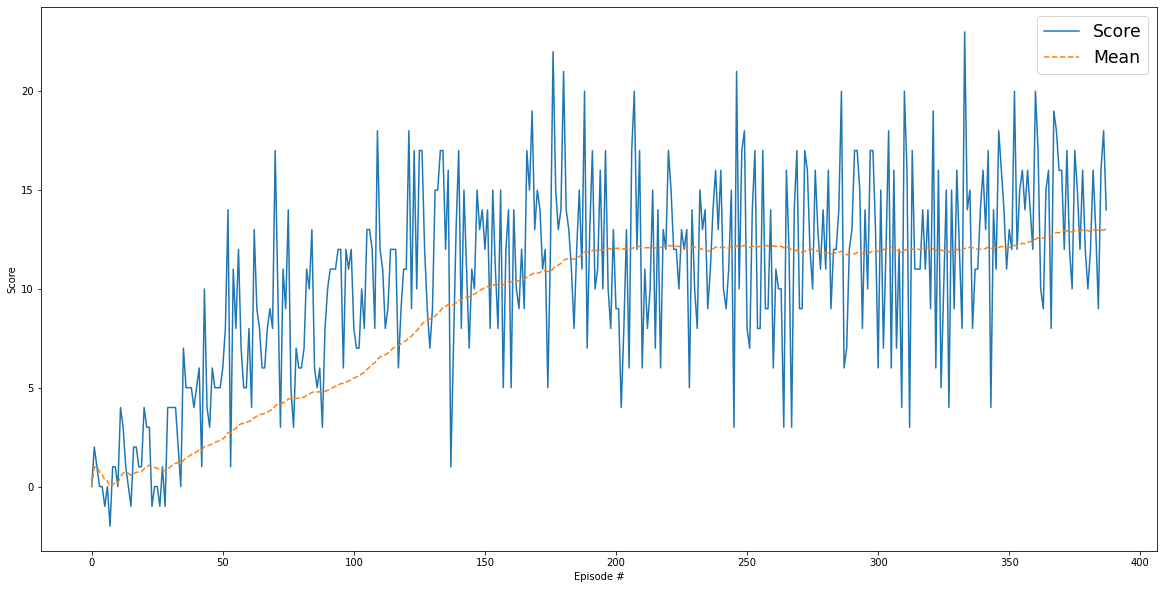

In [10]:
train(agent, weights_file)

Episode 1	Score: 14.00
Episode 2	Score: 15.00
Episode 3	Score: 17.00
Episode 4	Score: 12.00
Episode 5	Score: 16.00
Episode 6	Score: 7.00
Episode 7	Score: 19.00
Episode 8	Score: 24.00
Episode 9	Score: 13.00
Episode 10	Score: 15.00
Episode 11	Score: 18.00
Episode 12	Score: 14.00
Episode 13	Score: 17.00
Episode 14	Score: 16.00
Episode 15	Score: 18.00
Episode 16	Score: 25.00
Episode 17	Score: 5.00
Episode 18	Score: 18.00
Episode 19	Score: 17.00
Episode 20	Score: 12.00
Episode 21	Score: 9.000
Episode 22	Score: 18.00
Episode 23	Score: 18.00
Episode 24	Score: 19.00
Episode 25	Score: 15.00
Episode 26	Score: 14.00
Episode 27	Score: 4.00
Episode 28	Score: 15.00
Episode 29	Score: 16.00
Episode 30	Score: 0.00
Episode 31	Score: 16.00
Episode 32	Score: 4.00
Episode 33	Score: 16.00
Episode 34	Score: 7.00
Episode 35	Score: 12.00
Episode 36	Score: 3.00
Episode 37	Score: 18.00
Episode 38	Score: 15.00
Episode 39	Score: 12.00
Episode 40	Score: 9.00
Episode 41	Score: 15.00
Episode 42	Score: 13.00
Episode 4

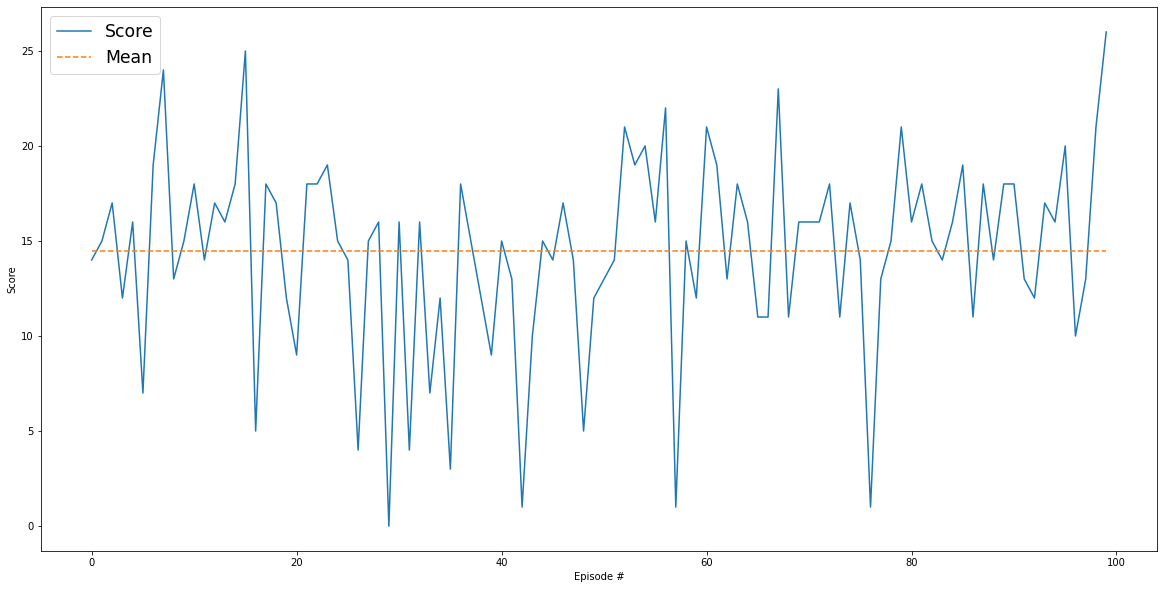

In [11]:
evaluate(env, agent, episodes=100, weights_file=weights_file)

#### Double DQN Agent
Train an **Double DQN Agent** and evaluate it over 100 eposiodes.

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, double_dqn=True, dueling_network=False, prioritized_replay=False)
weights_file = 'weights/checkpoint_ddqn.pth'

Skip training to use the pretrained weights.

Episode 100	Average Score: 6.31
Episode 200	Average Score: 11.53
Episode 289	Average Score: 13.04
Environment solved in 289 episodes!	Average Score: 13.04


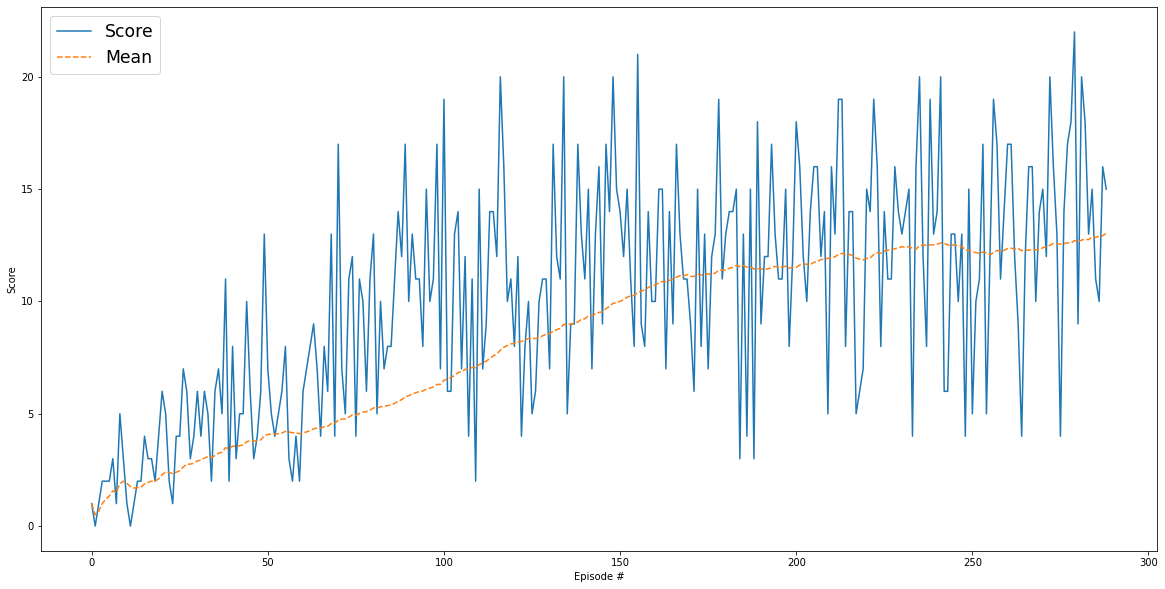

In [13]:
train(agent, weights_file)

Episode 1	Score: 13.00
Episode 2	Score: 17.00
Episode 3	Score: 10.00
Episode 4	Score: 12.00
Episode 5	Score: 9.00
Episode 6	Score: 15.00
Episode 7	Score: 15.00
Episode 8	Score: 23.00
Episode 9	Score: 13.00
Episode 10	Score: 22.00
Episode 11	Score: 14.00
Episode 12	Score: 19.00
Episode 13	Score: 19.00
Episode 14	Score: 16.00
Episode 15	Score: 13.00
Episode 16	Score: 10.00
Episode 17	Score: 19.00
Episode 18	Score: 15.00
Episode 19	Score: 15.00
Episode 20	Score: 13.00
Episode 21	Score: 11.00
Episode 22	Score: 18.00
Episode 23	Score: 14.00
Episode 24	Score: 12.00
Episode 25	Score: 14.00
Episode 26	Score: 17.00
Episode 27	Score: 19.00
Episode 28	Score: 14.00
Episode 29	Score: 13.00
Episode 30	Score: 22.00
Episode 31	Score: 15.00
Episode 32	Score: 17.00
Episode 33	Score: 17.00
Episode 34	Score: 15.00
Episode 35	Score: 10.00
Episode 36	Score: 17.00
Episode 37	Score: 16.00
Episode 38	Score: 9.00
Episode 39	Score: 17.00
Episode 40	Score: 0.00
Episode 41	Score: 19.00
Episode 42	Score: 19.00
Epis

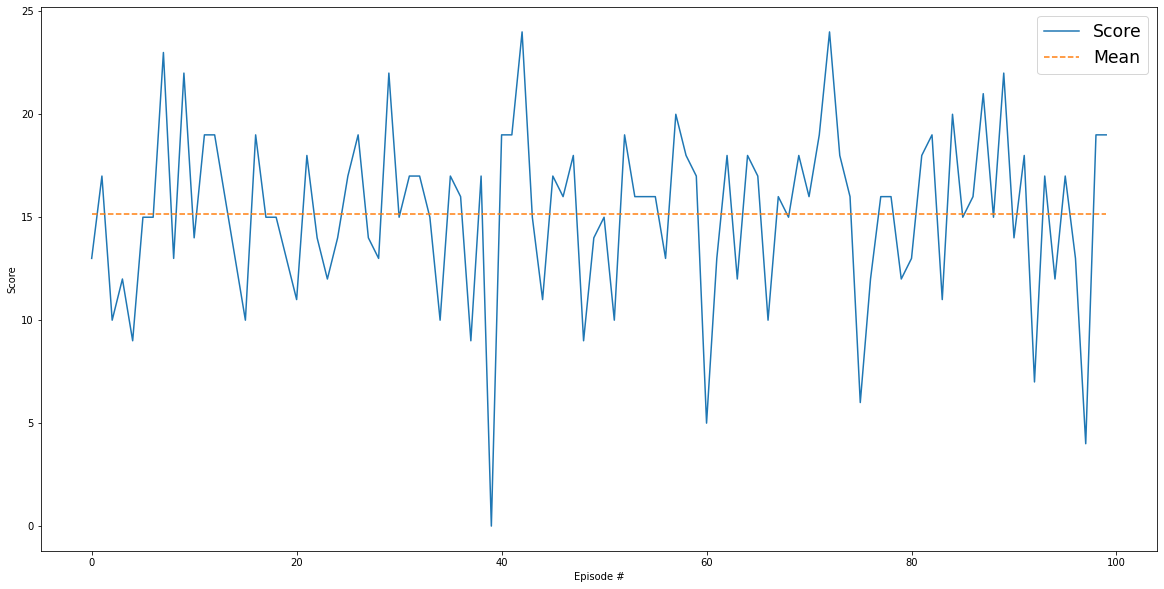

In [14]:
evaluate(env, agent, episodes=100, weights_file=weights_file)

#### Dueling DQN Agent
Train an **Dueling DQN Agent** and evaluate it over 100 eposiodes.

In [15]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, double_dqn=True, dueling_network=True, prioritized_replay=False)
weights_file = 'weights/checkpoint_ddqn_dueling_nw.pth'

Skip training to use the pretrained weights.

Episode 100	Average Score: 3.24
Episode 200	Average Score: 9.40
Episode 273	Average Score: 13.00
Environment solved in 273 episodes!	Average Score: 13.00


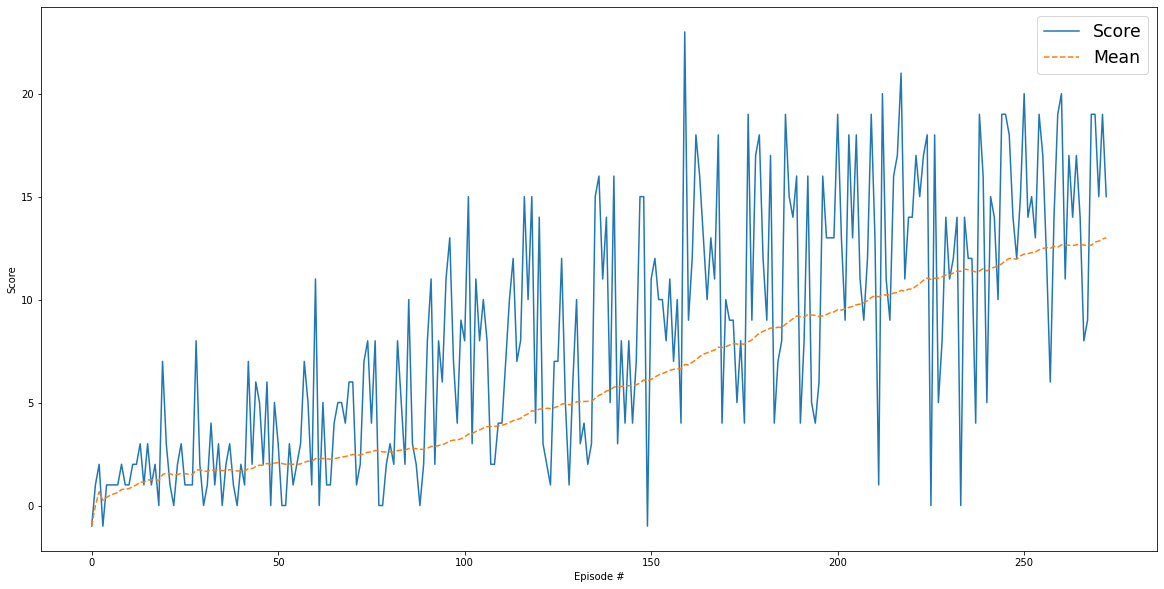

In [16]:
train(agent, weights_file)

Episode 1	Score: 20.00
Episode 2	Score: 9.00
Episode 3	Score: 16.00
Episode 4	Score: 16.00
Episode 5	Score: 21.00
Episode 6	Score: 17.00
Episode 7	Score: 18.00
Episode 8	Score: 19.00
Episode 9	Score: 5.00
Episode 10	Score: 13.00
Episode 11	Score: 22.00
Episode 12	Score: 12.00
Episode 13	Score: 14.00
Episode 14	Score: 10.00
Episode 15	Score: 10.00
Episode 16	Score: 14.00
Episode 17	Score: 14.00
Episode 18	Score: 11.00
Episode 19	Score: 12.00
Episode 20	Score: 17.00
Episode 21	Score: 8.00
Episode 22	Score: 17.00
Episode 23	Score: 0.00
Episode 24	Score: 19.00
Episode 25	Score: 19.00
Episode 26	Score: 11.00
Episode 27	Score: 14.00
Episode 28	Score: 13.00
Episode 29	Score: 16.00
Episode 30	Score: 14.00
Episode 31	Score: 13.00
Episode 32	Score: 3.00
Episode 33	Score: 18.00
Episode 34	Score: 14.00
Episode 35	Score: 16.00
Episode 36	Score: 19.00
Episode 37	Score: 10.00
Episode 38	Score: 12.00
Episode 39	Score: 5.00
Episode 40	Score: 19.00
Episode 41	Score: 13.00
Episode 42	Score: 14.00
Episode

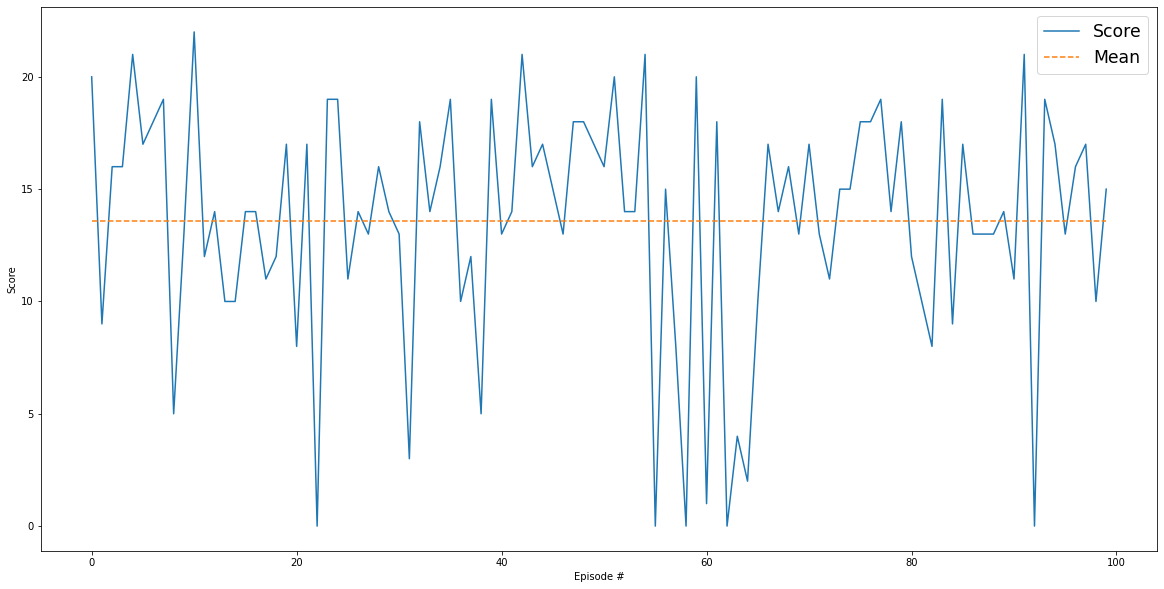

In [17]:
evaluate(env, agent, episodes=100, weights_file=weights_file)

#### Dueling DQN Agent with Prioritized Experience Replay
Train an **Double DQN Agent with Prioritized Experience Replay** and evaluate it over 100 eposiodes.

In [18]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, double_dqn=True, dueling_network=True, prioritized_replay=True)
weights_file = 'weights/checkpoint_ddqn_dueling_nw_prioritized.pth'

Skip training to use the pretrained weights.

Episode 100	Average Score: 2.94
Episode 200	Average Score: 7.39
Episode 300	Average Score: 12.08
Episode 339	Average Score: 13.09
Environment solved in 339 episodes!	Average Score: 13.09


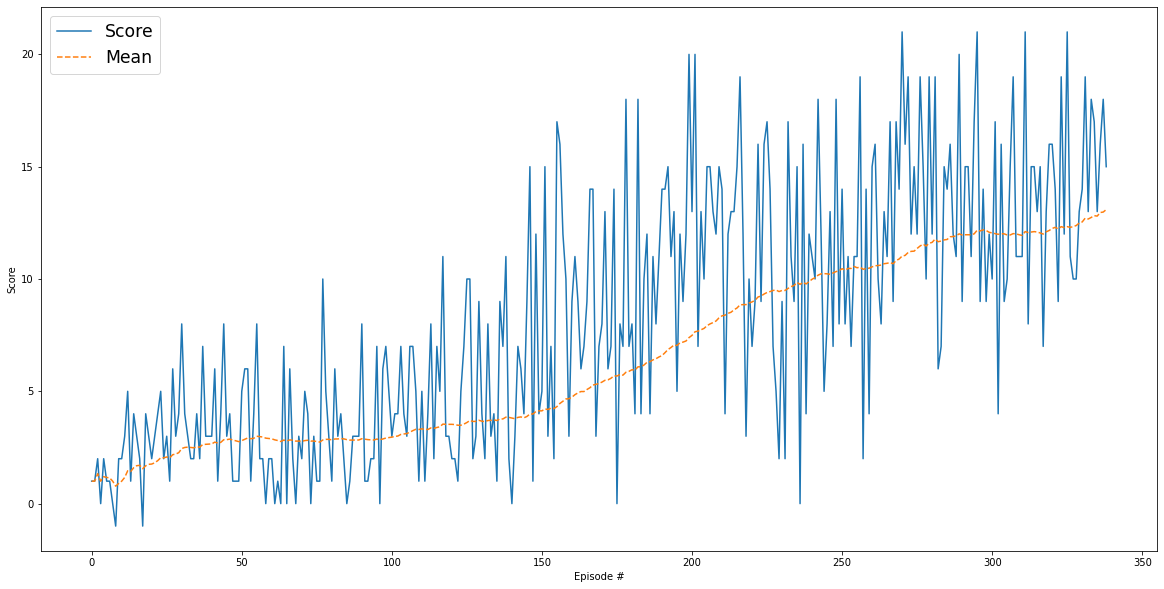

In [19]:
train(agent, weights_file)

Episode 1	Score: 13.00
Episode 2	Score: 8.000
Episode 3	Score: 12.00
Episode 4	Score: 7.00
Episode 5	Score: 11.00
Episode 6	Score: 18.00
Episode 7	Score: 19.00
Episode 8	Score: 15.00
Episode 9	Score: 17.00
Episode 10	Score: 13.00
Episode 11	Score: 3.00
Episode 12	Score: 16.00
Episode 13	Score: 15.00
Episode 14	Score: 16.00
Episode 15	Score: 0.00
Episode 16	Score: 14.00
Episode 17	Score: 10.00
Episode 18	Score: 19.00
Episode 19	Score: 13.00
Episode 20	Score: 18.00
Episode 21	Score: 12.00
Episode 22	Score: 13.00
Episode 23	Score: 14.00
Episode 24	Score: 11.00
Episode 25	Score: 19.00
Episode 26	Score: 16.00
Episode 27	Score: 16.00
Episode 28	Score: 11.00
Episode 29	Score: 17.00
Episode 30	Score: 16.00
Episode 31	Score: 19.00
Episode 32	Score: 16.00
Episode 33	Score: 17.00
Episode 34	Score: 17.00
Episode 35	Score: 20.00
Episode 36	Score: 3.000
Episode 37	Score: 16.00
Episode 38	Score: 14.00
Episode 39	Score: 6.00
Episode 40	Score: 4.00
Episode 41	Score: 14.00
Episode 42	Score: 22.00
Episod

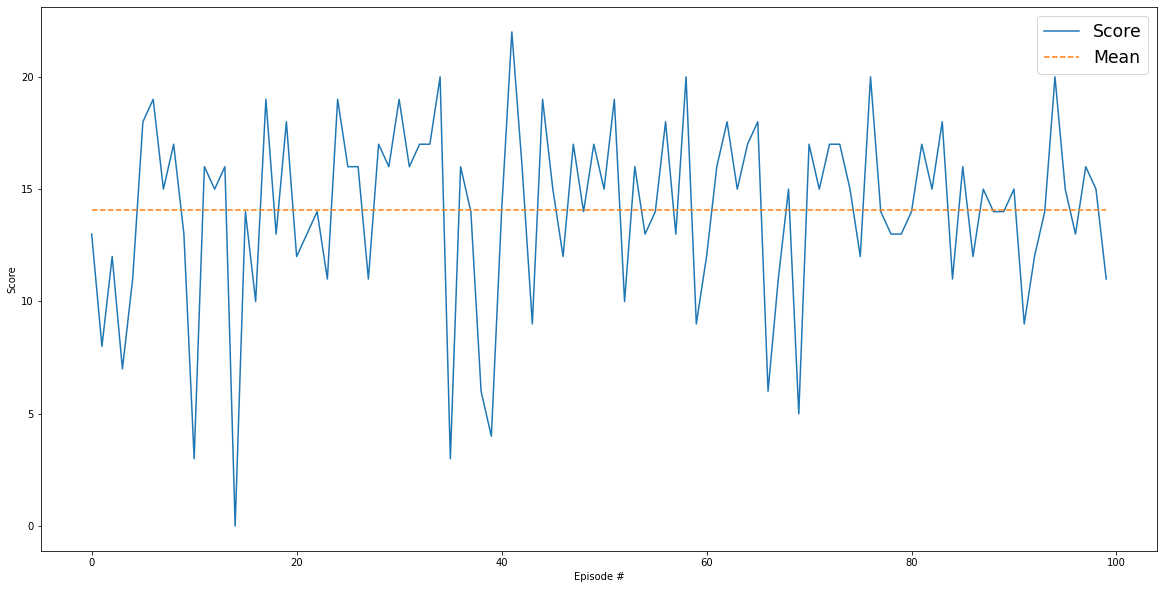

In [20]:
evaluate(env, agent, episodes=100, weights_file=weights_file)

Close the environment

In [21]:
env.close()

#### Conclusion

The following table shows the evaluation results of the different agents:

Agent                                         | Training Episodes | Average Score (Evaluation) 
:---------------------------------------------| ----------------: | --------------------------: 
Singe DQN                                     | 388               | 14.47 
Double DQN                                    | 289               | 15.18  
Dueling DQN                                   | 237               | 13.60  
Dueling DQN and Prioritized Experience Replay | 339               | 14.08  


The results of the different agents are pretty close together. The **Double DQN Agent** achieved the best result. 
With a relatively short training time of **289** episodes, this achieved an average score of **15.18** in the evaluation over **100** episodes.
